In [1]:
import glob
import numpy as np
import pandas as pd 
from collections import defaultdict
from math import isclose
%matplotlib inline
# produce vector inline graphics
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')
import matplotlib.pyplot as plt
import seaborn as sns
import random
import scipy.stats


def conf_int(data, axis=0, alpha=0.95):
    return scipy.stats.sem(data, axis=axis) * scipy.stats.t.ppf((1 + alpha) / 2., data.shape[axis]-1)


/tmp/ipykernel_469091/2057882253.py:9: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('pdf', 'svg')


In [1]:


#Load DTM
import rasterio as rio
import csv
import shapely.wkt as wkt
from rasterio import mask, features

dtms = {}
max_dist =  300
for a in ['firenze']:
    with open(f'{a}.csv') as sacsv:
        subareas_csv = list(csv.reader(sacsv, delimiter=','))
    dataset = rio.open(f'/home/gabriele.gemmi/nfs/gabriel/data/dtm_fusion/{a}_dtm.tif')
    for sa in subareas_csv:
        sa_id = sa[1]
        sa_wkt = sa[0]
        sub_area = wkt.loads(sa_wkt)
        buffered_area = sub_area.buffer(max_dist/2)
        dataset_crop, rm_transform = rio.mask.mask(dataset, [buffered_area], crop=True, indexes=1)
        dtms[(a,sa_id)] = dataset_crop
        


In [4]:
runs = glob.glob('/home/gabriele.gemmi/nfs/gabriel/results/TNSM2022/results_rebuttal/*/threestep/*/r1/1/*/*/')


bad = 0
good = 0
results = []
for r in runs[:2]:
    max_angles = []
    min_distances = []
    prefix, subpath = r.split('results_rebuttal')
    params =  subpath.split('/')
    area, strat, sa, rf, k, ratio, dens = params[1:-1]

    bp = prefix+'results_rebuttal'+'/'.join(params[:4])
    invmat = np.load(f'{bp}/inverse_translation_matrix.npy')
    viewsheds = np.load(f'{r}/viewsheds.npy')
    nodes = pd.read_csv(f'{r}/index.csv', 
                    sep=' ', 
                    header=0, 
                    names=['x', 'y', 'z', 'x_3003', 'y_3003', 'b', 'p_i']
                    ).set_index('p_i')
    for n in nodes.index:
        src_p = np.array([nodes.loc[n].x, nodes.loc[n].y]).astype(int)
        for idx, p in enumerate(viewsheds[:, n]):
            d = np.linalg.norm(src_p -invmat[idx+1])
            results.append({'dist': d, 'los': p})


results = pd.DataFrame(results)

In [11]:
import math as m

thisres = results[results.dist<300]

los_p = []
space = np.linspace(0,300,300, endpoint=False)
for i in range(len(space)-1):
    d = space[i]+space[i+1]
    vals = thisres[(thisres.dist>space[i]) & (thisres.dist<space[i+1])].los.values
    p_exp = vals.mean()
    #p_exp_ci = conf_int(p_exp)
    if d<18:
        p_etsi = 1
    else:
        p_etsi = (18 + d*m.e**(-d/36) - 18*m.e**(-d/36))/d
    los_p.append({'distance (m)': (d)/2, 'type':'TrueNets', 'p': p_exp, 'p_etsi': p_etsi})
    los_p.append({'distance (m)': (d)/2, 'type':'ETSI UMi', 'p': p_etsi})

los_p = pd.DataFrame(los_p)





/tmp/ipykernel_466557/561349893.py:10: RuntimeWarning: Mean of empty slice.
  p_exp = vals.mean()
/home/gabriele.gemmi/.virtualenvs/truenets/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


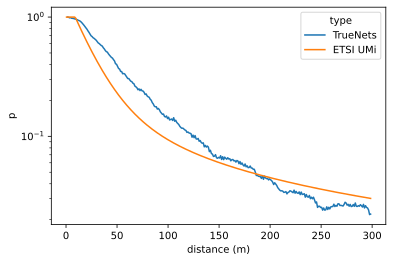

In [12]:
sns.lineplot(data=los_p, x='distance (m)', y='p', hue='type')
plt.yscale('log')

In [22]:
runs = glob.glob('/home/gabriele.gemmi/nfs/gabriel/results/TNSM2022/results_rebuttal/*/threestep/*/r1/1/*/*/')

bad = 0
good = 0
results = []
for r in runs[:2]:
    max_angles = []
    min_distances = []
    prefix, subpath = r.split('results_rebuttal')
    params =  subpath.split('/')
    area, strat, sa, rf, k, ratio, dens = params[1:-1]

    bp = prefix+'results_rebuttal'+'/'.join(params[:4])
    invmat = np.load(f'{bp}/inverse_translation_matrix.npy')
    viewsheds = np.load(f'{r}/viewsheds.npy')
    nodes = pd.read_csv(f'{r}/index.csv', 
                    sep=' ', 
                    header=0, 
                    names=['x', 'y', 'z', 'x_3003', 'y_3003', 'b', 'p_i']
                    ).set_index('p_i')
    for n in nodes.index:
        src_p = np.array([nodes.loc[n].x, nodes.loc[n].y]).astype(int)
        ues = np.argwhere(viewsheds[:, n])
        for ue in ues:
            dist = src_p -invmat[ue+1]
            d = np.linalg.norm(dist)
            results.append({'dist': d, 'd_x': abs(dist[0,0]//2), 'd_y': abs(dist[0,1]//2)})


results = pd.DataFrame(results)

In [26]:
import scipy.stats as stats

for d in range(0,50,3):
    slice =  results[results.dist<=d]
    cs = pd.crosstab(slice.d_x, slice.d_y)
    c,p,v,a = stats.chi2_contingency(cs)
    print(v)

0
4
9
25
36
64
81
121
144
196
225
289
324
400
441
529
576
